# Laboratorium 3 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab3`
 * zainstaluj potrzebne biblioteki:
 `pip install matplotlib`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [1]:
from copy import copy
from math import log, sqrt
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # w tym pakiet ze srodowiskiem testowym

In [2]:
# inicjalizujemy parametry testu

arms_number = 50
runs = 50
epochs = 1440
recommendation_size = 10

In [3]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny

arms = {}
for i in range(50):
    activation_probability = uniform(0.01, 0.7)
    mu = uniform(0.1, 2.5)
    sigma = min(uniform(0.1, 1), mu)
    arms['%s' % i] = Arm('%s' % i, activation_probability, lambda: normalvariate(mu, sigma))

arm_ids = list(arms.keys())

In [6]:
# pierwszy bandyta - wybiera losowe ramiona
import random

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        arm_len = len(self.arm_ids)
        return [self.arm_ids[random.randint(0, arm_len-1)] for i in range(size)]
    
    def feedback(self, arm_id, payout):
        pass

In [7]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalexc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [8]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [9]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 13748.78141427248
random: 7805.388550067496


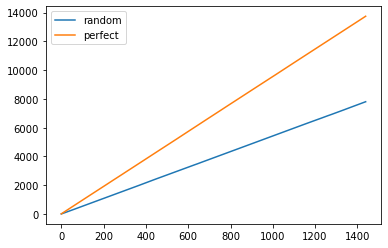

In [10]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 8.96356677083774
random: 5.750106189484764


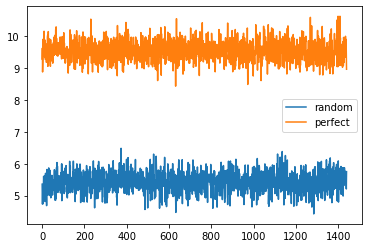

In [11]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [12]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        top_n = [x[0] for x in sorted(self.payouts_per_recommendation.items(), key=lambda x: x[1], reverse=True)]#[:size]
        randomized = copy(self.arm_ids)
        shuffle(randomized)
        
        recommendation = set()
        i = 0
        while len(recommendation) < size:
            rand = random.random()
            recommendation.add(top_n[i] if rand > self.epsilon else randomized[i])
            i += 1
            
        recommendation = list(recommendation)
        for x in recommendation:
            self.recommended_rates[x] += 1
        return recommendation
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

In [13]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.recommended_rates = {arm_id: 1 for arm_id in arm_ids}# = impresje, ile razy user pokazalismy
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        ucb_score = {arm: self.payouts_per_recommendation[arm] + self._optimism(arm) for arm in arm_ids}
        
        recommendation = [x[0] for x in sorted(ucb_score.items(), key=lambda x: x[1], reverse=True)][:size]

        for x in recommendation:
            self.recommended_rates[x] += 1
        return recommendation
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

    def _optimism(self, arm):
        sum_impressions = sum(value for arm_id, value in self.recommended_rates.items())
        return sqrt((2 * log(sum_impressions)) / self.recommended_rates[arm])

In [14]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        beta_randoms = {arm_id: betavariate(self.a[arm_id], self.b[arm_id]) for arm_id in self.arm_ids}
        recommendation = [x[0] for x in sorted(beta_randoms.items(), key=lambda x: x[1], reverse=True)][:size]
        return recommendation
    
    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1 - payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Część 3. - porównanie bandytów

In [15]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in [(1, 1), (10, 1), (1, 10), (10, 10)]])


In [16]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_10_1
Simulating: ts_1_10
Simulating: ts_10_10



Aggregated results:

perfect: 13772.49975187471
ts_1_1: 13742.825951425473
ts_1_10: 13740.34789616129
ucb_10: 13683.082792210122
ucb_1: 13678.497958521877
ucb_0.01: 13676.593342569131
ucb_0.1: 13665.041706553026
ts_10_1: 13613.723294516267
egreedy_0.01: 13582.215638470401
egreedy_0.05: 13440.257645439404
ts_10_10: 13393.14998744756
egreedy_0.1: 13093.712178294785
egreedy_0.25: 12215.16841514272
random: 7828.378398796364


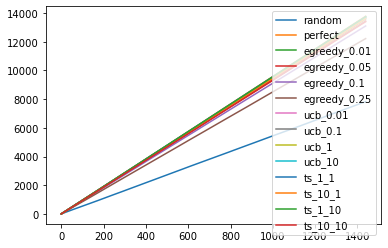

In [17]:
runner.plot_results(results, runs, epochs, mode='cumulative')